In [19]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from sklearn.metrics import confusion_matrix, classification_report
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage import io
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import os
import h5py


In [20]:
import tensorflow as tf
print(tf.__version__)


2.15.0


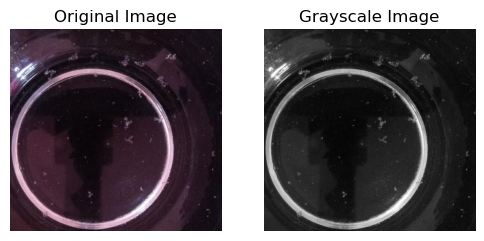

Found 722 images belonging to 2 classes.
Found 323 images belonging to 2 classes.


In [22]:
# Providing the Paths to the Training, Validation, and Testing data
training_path = 'C:/Users/vikra/Downloads/Naveen/images 1/images/train'
validation_path = 'C:/Users/vikra/Downloads/Naveen/images 1/images/valid'
testing_path = 'C:/Users/vikra/Downloads/Naveen/images 1/images/test2'

# Resizing the jpgs to 128x128 to reduce processing needs and to provide uniform images
def resize_images(image):
    resized_image = resize(image.squeeze(), (128, 128))
    return np.expand_dims(resized_image, axis=-1)

# Loading the JPGs as B&W to save memory
def rgb_to_gray(image):
    return rgb2gray(image)

# Loading an example RGB image
image = io.imread('C:/Users/vikra/Downloads/Naveen/images 1/images/train2/Microplastics/5_jpg.rf.bae5eab1f3f565c87534464393ff620a.jpg')  # Replace with your image path
 
# Convert the RGB image to grayscale
gray_image = rgb_to_gray(image)
 
# Display the original and grayscale images
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
ax = axes.ravel()
 
# Original Image
ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[0].axis('off')
 
# Grayscale Image
ax[1].imshow(gray_image, cmap='gray')
ax[1].set_title('Grayscale Image')
ax[1].axis('off')
plt.show()

# Setting random seeds for Numpy & TensorFlow for reproducibility
np.random.seed(14)
tf.random.set_seed(14)

# All jpgs should be the same size (128,128)
# Rescaling in anticipation of Neural Networking modeling later in the process.
# Allowing for some variation in image orientation.
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    preprocessing_function=lambda x: resize(x.squeeze(), (128, 128)),
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

# Fitting the ImageDataGenerator onto the Training data
datagen.fit(np.zeros((1, 128, 128, 3)))

# Defining Training and Validation sets
train_generator = datagen.flow_from_directory(
    training_path,
    target_size=(128, 128),
    batch_size=1154,
    class_mode='binary',
)

validation_generator = datagen.flow_from_directory(
    validation_path,
    target_size=(128, 128),
    batch_size=208,
    class_mode='binary',
)

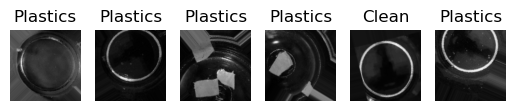

In [24]:
batch = next(train_generator)

# Extracting the images and labels from the batch
images, labels = batch

# Updating labels for better readability
updated_labels = ["Clean" if label == 0 else "Plastics" for label in labels]

# Displaying the first few images along with their labels
num_images_to_display = 6
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(images[i][:, :, 0], cmap='gray')
    plt.title(f"{updated_labels[i]}")
    plt.axis('off')

plt.show()

In [25]:
# checking the shape of the output from the resizing
sample_batch = next(train_generator)
sample_image = sample_batch[0][0]
print("Shape after resize_images:", sample_image.shape)

Shape after resize_images: (128, 128, 3)


In [26]:
# Building the Image Classification Model, using Convolutional Neural Network, via MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freezing the convolutional base
base_model.trainable = False

# Modeling with classification head on top of MobileNetV2
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(128, activation='elu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='leaky_relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

# Compiling the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
# Training the Model
epochs = 50

history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=validation_generator)

# Generating Evaluation from the Training & Validation Sets
train_loss, train_accuracy = model.evaluate(train_generator)
valid_loss, valid_accuracy = model.evaluate(validation_generator)

# Displaying accuracy & loss.
print(f'Training Accuracy: {train_accuracy}')
print(f'Training Loss: {train_loss}')
print(f'----------------------------------------')
print(f'Validation Accuracy: {valid_accuracy}')
print(f'Validation Loss: {valid_loss}')

Epoch 1/50
1/1 [==============================] - 34s 34s/step - loss: 0.6816 - accuracy: 0.6080 - val_loss: 1.1529 - val_accuracy: 0.6316
Epoch 2/50
1/1 [==============================] - 22s 22s/step - loss: 0.6725 - accuracy: 0.7992 - val_loss: 0.7639 - val_accuracy: 0.6316
Epoch 3/50
1/1 [==============================] - 22s 22s/step - loss: 0.4828 - accuracy: 0.8006 - val_loss: 0.4094 - val_accuracy: 0.6935
Epoch 4/50
1/1 [==============================] - 22s 22s/step - loss: 0.3277 - accuracy: 0.8560 - val_loss: 0.2894 - val_accuracy: 0.9876
Epoch 5/50
1/1 [==============================] - 22s 22s/step - loss: 0.3198 - accuracy: 0.8878 - val_loss: 0.2505 - val_accuracy: 0.9907
Epoch 6/50
1/1 [==============================] - 23s 23s/step - loss: 0.2771 - accuracy: 0.9197 - val_loss: 0.2002 - val_accuracy: 0.9752
Epoch 7/50
1/1 [==============================] - 22s 22s/step - loss: 0.2206 - accuracy: 0.9404 - val_loss: 0.1902 - val_accuracy: 0.9412
Epoch 8/50
1/1 [===========

In [28]:
# Evaluating the model on the testing set
test_generator = datagen.flow_from_directory(
    testing_path,
    target_size=(128, 128),
    batch_size=200,
    class_mode='binary',
    shuffle=True,

)

# Generating Evaluation from the testing set
test_loss, test_accuracy = model.evaluate(test_generator)

# Displaying accuracy & loss
print(f'Testing Accuracy: {test_accuracy}')
print(f'Testing Loss: {test_loss}')

Found 261 images belonging to 2 classes.
2/2 [==============================] - 10s 2s/step - loss: 7.9344 - accuracy: 0.3793
Testing Accuracy: 0.37931033968925476
Testing Loss: 7.934375762939453


2/2 [==============================] - 11s 2s/step
Confusion Matrix:
[[ 37 107]
 [ 35  82]]


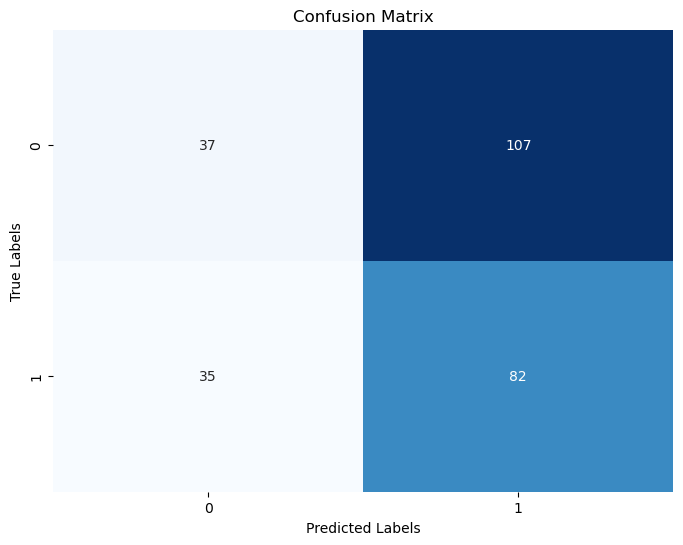

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.26      0.34       144
           1       0.43      0.70      0.54       117

    accuracy                           0.46       261
   macro avg       0.47      0.48      0.44       261
weighted avg       0.48      0.46      0.43       261

Testing Accuracy: 0.37931033968925476
Testing Loss: 7.934375762939453


In [29]:
# Generating predictions on the testing set
predictions = model.predict(test_generator)

# Converting predictions to binary values (0 or 1)
binary_predictions = (predictions > 0.5).astype(int)

# Getting true labels from the generator
true_labels = test_generator.classes

# Displaying confusion matrix
conf_matrix = confusion_matrix(true_labels, binary_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Assuming binary_predictions and true_labels are already defined as in your provided code

conf_matrix = confusion_matrix(true_labels, binary_predictions)
 
# Plotting the confusion matrix

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

 

# Displaying classification report
classification_rep = classification_report(true_labels, binary_predictions)
print("Classification Report:")
print(classification_rep)

# Displaying accuracy & loss
print(f'Testing Accuracy: {test_accuracy}')
print(f'Testing Loss: {test_loss}')

In [30]:
# Comparing the True Labels to the Predicted Labels
print("True Labels:")
print(true_labels)
print(f'---------------------------------------------------------')
print("Testing Predicted Labels:")
print(binary_predictions.flatten())

True Labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]
---------------------------------------------------------
Testing Predicted Labels:
[1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1
 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 1 0 1 1 0 1 1 0 1 1 0 0 0 1 1 1 1 0 0 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 1 1 0 1 1 1 0 0 1 1

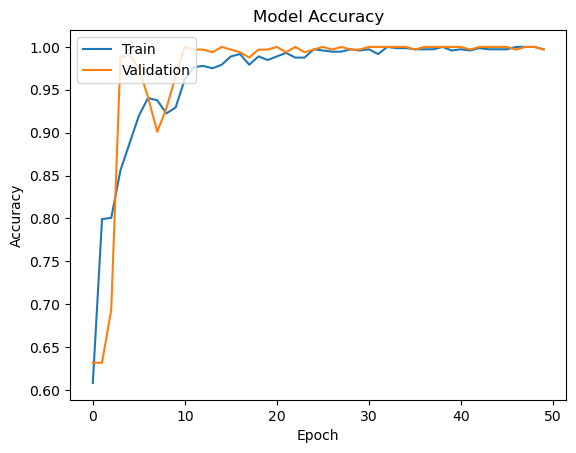

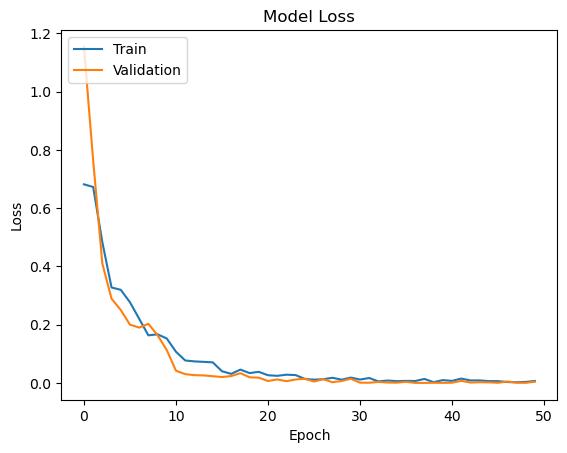

In [31]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [32]:
# Creating activation list
activation_functions = ['leaky_relu', 'elu', 'tanh', 'selu', 'sigmoid', 'relu']

# Creating a dictionary to hold the activation function accuracy results
results = {}

# For-Looping the activation functions through the model
for activation in activation_functions:
    print(f"Training model with activation: {activation}")

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation=activation),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Training the model
    history = model.fit(train_generator, epochs=15, validation_data=validation_generator)

    # Pulling the results
    results[activation] = history.history['val_accuracy']

# Plotting the results
plt.figure(figsize=(10, 6))

Training model with activation: leaky_relu
Epoch 1/15
1/1 [==============================] - 15s 15s/step - loss: 1.0541 - accuracy: 0.4958 - val_loss: 0.9945 - val_accuracy: 0.6316
Epoch 2/15
1/1 [==============================] - 11s 11s/step - loss: 0.6057 - accuracy: 0.7770 - val_loss: 1.2042 - val_accuracy: 0.6316
Epoch 3/15
1/1 [==============================] - 11s 11s/step - loss: 0.6832 - accuracy: 0.7936 - val_loss: 1.0541 - val_accuracy: 0.6316
Epoch 4/15
1/1 [==============================] - 11s 11s/step - loss: 0.6079 - accuracy: 0.8019 - val_loss: 0.8320 - val_accuracy: 0.6316
Epoch 5/15
1/1 [==============================] - 11s 11s/step - loss: 0.4945 - accuracy: 0.8047 - val_loss: 0.6036 - val_accuracy: 0.6316
Epoch 6/15
1/1 [==============================] - 11s 11s/step - loss: 0.3929 - accuracy: 0.8199 - val_loss: 0.4248 - val_accuracy: 0.6625
Epoch 7/15
1/1 [==============================] - 11s 11s/step - loss: 0.3429 - accuracy: 0.8518 - val_loss: 0.3089 - val_a

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

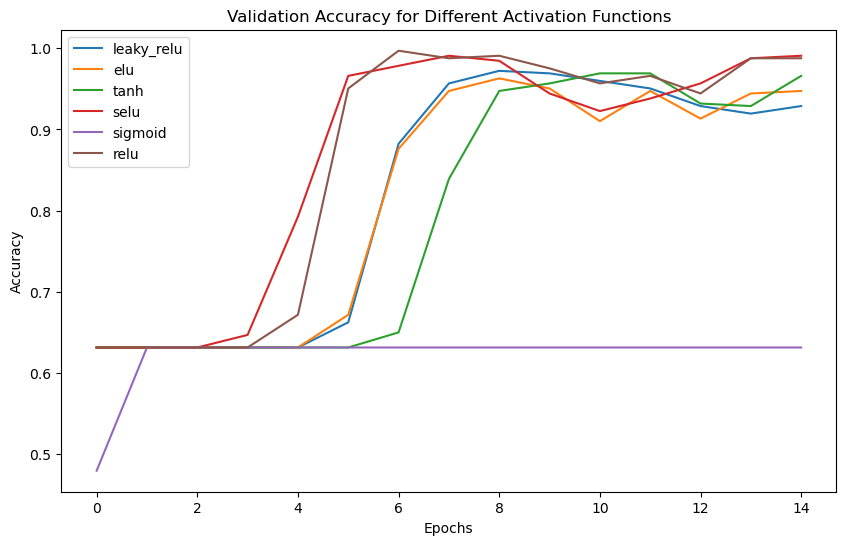

In [33]:
# Plot the results
plt.figure(figsize=(10, 6))
for activation, accuracy in results.items():
    plt.plot(accuracy, label=activation)

plt.title('Validation Accuracy for Different Activation Functions')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

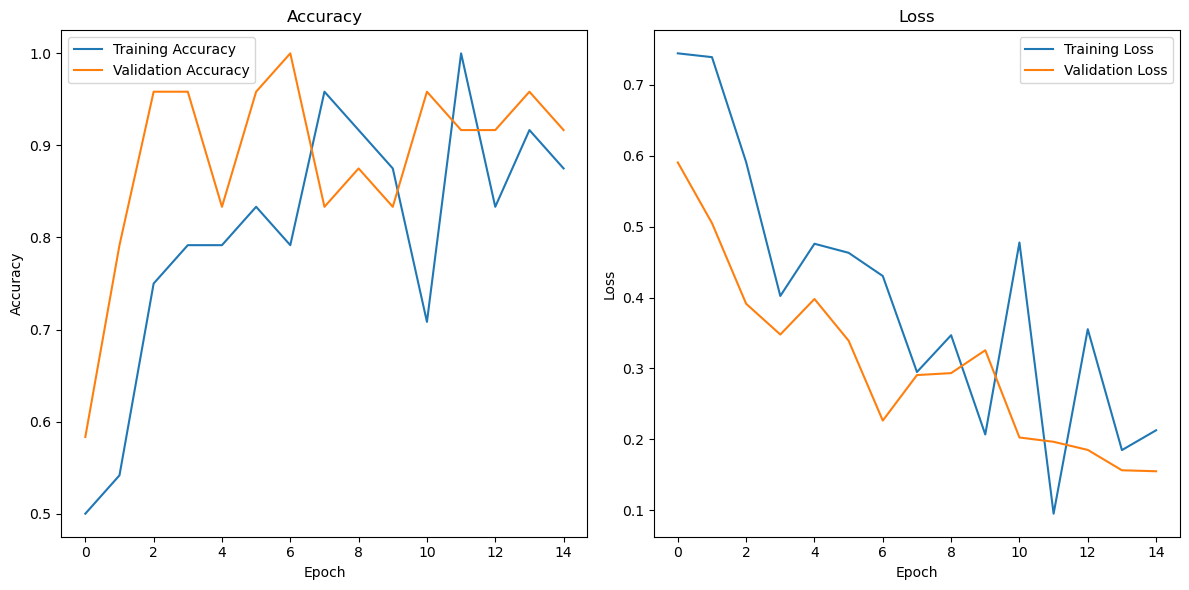

In [28]:
import matplotlib.pyplot as plt
 
# Plot Training & Validation Accuracy
plt.figure(figsize=(12, 6))
 
# Plot Training Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
 
# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
 
plt.tight_layout()
plt.show()

In [14]:
pip install keras-tuner

  Obtaining dependency information for keras-tuner from https://files.pythonhosted.org/packages/db/5d/945296512980b0827e93418514c8be9236baa6f0a1e8ca8be3a2026665b0/keras_tuner-1.4.7-py3-none-any.whl.metadata
  Obtaining dependency information for kt-legacy from https://files.pythonhosted.org/packages/16/53/aca9f36da2516db008017db85a1f3cafaee0efc5fc7a25d94c909651792f/kt_legacy-1.0.5-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   -------------------------------------- - 122.9/129.1 kB 2.4 MB/s eta 0:00:01
   ---------------------------------------- 129.1/129.1 kB 1.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [16]:
import tensorflow as tf
import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
 
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(filters=hp.Int('filters1', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Choice('kernel_size1', values=[3, 5]),
                     activation='relu',
                     input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=hp.Int('filters2', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Choice('kernel_size2', values=[3, 5]),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=hp.Int('units', min_value=64, max_value=256, step=64),
                    activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.3, max_value=0.6, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
 
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='my_dir',
    project_name='intro_to_kt'
)
 
# Perform the hyperparameter search
tuner.search(train_generator,
             epochs=50,
             validation_data=validation_generator)
 
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

Trial 90 Complete [00h 02m 10s]
val_accuracy: 0.7916666865348816

Best val_accuracy So Far: 0.875
Total elapsed time: 00h 50m 59s
Best hyperparameters: {'filters1': 96, 'kernel_size1': 5, 'filters2': 32, 'kernel_size2': 3, 'units': 256, 'dropout': 0.3, 'learning_rate': 0.00045072104393307306, 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0080'}


In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
 
# Best hyperparameters found by Keras Tuner
best_hps = {
    'filters1': 96,
    'kernel_size1': 5,
    'filters2': 32,
    'kernel_size2': 3,
    'units': 256,
    'dropout': 0.3,
    'learning_rate': 0.00045072104393307306
}
 
# Build the final model
def build_final_model(hp):
    model = Sequential([
        Conv2D(filters=hp['filters1'], kernel_size=hp['kernel_size1'], activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=hp['filters2'], kernel_size=hp['kernel_size2'], activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(hp['units'], activation='relu'),
        Dropout(hp['dropout']),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=hp['learning_rate']),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
 
# Create the final model
final_model = build_final_model(best_hps)
 
# Train the final model
final_model.fit(train_generator, epochs=50, validation_data=validation_generator)
 
# Evaluate the final model
test_loss, test_accuracy = final_model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
 
# Save the final model
final_model.save('optimized_microplastics_detection_model.h5')

Epoch 1/50
1/1 [==============================] - 6s 6s/step - loss: 43873.5195 - accuracy: 0.5000 - val_loss: 908502.4375 - val_accuracy: 0.5000
Epoch 2/50
1/1 [==============================] - 3s 3s/step - loss: 1308314.6250 - accuracy: 0.5000 - val_loss: 400196.2500 - val_accuracy: 0.5000
Epoch 3/50
1/1 [==============================] - 3s 3s/step - loss: 528608.5625 - accuracy: 0.5000 - val_loss: 61519.9688 - val_accuracy: 0.5000
Epoch 4/50
1/1 [==============================] - 2s 2s/step - loss: 79501.7812 - accuracy: 0.5000 - val_loss: 77830.8203 - val_accuracy: 0.5000
Epoch 5/50
1/1 [==============================] - 2s 2s/step - loss: 78811.6562 - accuracy: 0.4583 - val_loss: 68741.0625 - val_accuracy: 0.5000
Epoch 6/50
1/1 [==============================] - 2s 2s/step - loss: 69491.4062 - accuracy: 0.5000 - val_loss: 36809.0508 - val_accuracy: 0.5000
Epoch 7/50
1/1 [==============================] - 2s 2s/step - loss: 36342.8242 - accuracy: 0.5000 - val_loss: 13586.4375 - v

C:\Users\vikra\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize

 
# Resizing function
def resize_images(image):
    resized_image = resize(image.squeeze(), (128, 128))
    return np.expand_dims(resized_image, axis=-1)
 
# Data generators with augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    preprocessing_function=lambda x: resize(x.squeeze(), (128, 128)),
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
)
 
train_generator = datagen.flow_from_directory(
    training_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)
 
validation_generator = datagen.flow_from_directory(
    validation_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)
 
test_generator = datagen.flow_from_directory(
    testing_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)
 
# Build and compile the model
base_model = VGG16(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False
 
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
 
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])
 
# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
 
model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)
 
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
 
# Save the model
model.save('transfer_learning_microplastics_detection_model.keras')

Found 20 images belonging to 2 classes.
Found 4 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


C:\Users\vikra\anaconda3\Lib\site-packages\keras\src\preprocessing\image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
C:\Users\vikra\anaconda3\Lib\site-packages\keras\src\preprocessing\image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 0.7217 - accuracy: 0.3500 - val_loss: 0.5932 - val_accuracy: 1.0000
Epoch 2/50
1/1 [==============================] - 2s 2s/step - loss: 0.6396 - accuracy: 0.6000 - val_loss: 0.5959 - val_accuracy: 1.0000
Epoch 3/50
1/1 [==============================] - 2s 2s/step - loss: 0.7850 - accuracy: 0.5000 - val_loss: 0.5493 - val_accuracy: 1.0000
Epoch 4/50
1/1 [==============================] - 2s 2s/step - loss: 0.7621 - accuracy: 0.5500 - val_loss: 0.5475 - val_accuracy: 1.0000
Epoch 5/50
1/1 [==============================] - 2s 2s/step - loss: 0.6833 - accuracy: 0.6000 - val_loss: 0.5065 - val_accuracy: 1.0000
Epoch 6/50
1/1 [==============================] - 2s 2s/step - loss: 0.7363 - accuracy: 0.5500 - val_loss: 0.6116 - val_accuracy: 0.7500
Epoch 7/50
1/1 [==============================] - 2s 2s/step - loss: 0.4813 - accuracy: 0.8000 - val_loss: 0.4620 - val_accuracy: 1.0000
Epoch 8/50
1/1 [=========================

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize
 
# Data generators with augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    preprocessing_function=lambda x: resize(x.squeeze(), (128, 128)),
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
)
 
train_generator = datagen.flow_from_directory(
    training_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)
 
validation_generator = datagen.flow_from_directory(
    validation_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)
 
test_generator = datagen.flow_from_directory(
    testing_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)
 
# Fit the datagen on training data
train_data = np.concatenate([train_generator.next()[0] for i in range(train_generator.__len__())])
datagen.fit(train_data)
 
# Build and compile the model
base_model = VGG16(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model
 
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
 
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])
 
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
 
# Train the model
model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)
 
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
 
# Save the model
model.save('transfer_learning_microplastics_detection_model.keras')

Found 20 images belonging to 2 classes.
Found 4 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 44.9294 - accuracy: 0.6000 - val_loss: 0.0082 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - 2s 2s/step - loss: 34.8989 - accuracy: 0.5000 - val_loss: 41.0431 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - 2s 2s/step - loss: 31.2166 - accuracy: 0.6500 - val_loss: 28.0205 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/50
1/1 [==============================] - 2s 2s/step - loss: 23.9442 - accuracy: 0.5500 - val_loss: 33.4704 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 5/50
1/1 [==============================] - 2s 2s/step - loss: 18.8950 - accuracy: 0.7000 - val_loss: 12.7764 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 6/50
1/1 [==============================] - 2s 2s/step - loss: 17.1769 - accuracy: 0.6500 - 

Found 24 images belonging to 2 classes.
Found 24 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Training Model 1
Epoch 1/20
1/1 [==============================] - 4s 4s/step - loss: 0.6415 - accuracy: 0.8750 - val_loss: 0.5103 - val_accuracy: 0.7917
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 0.2869 - accuracy: 0.9167 - val_loss: 1.3788 - val_accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 2s 2s/step - loss: 0.7131 - accuracy: 0.5000 - val_loss: 0.4279 - val_accuracy: 0.9167
Epoch 4/20
1/1 [==============================] - 2s 2s/step - loss: 0.3663 - accuracy: 0.9167 - val_loss: 0.5158 - val_accuracy: 0.9167
Epoch 5/20
1/1 [==============================] - 2s 2s/step - loss: 0.5082 - accuracy: 0.9167 - val_loss: 0.4747 - val_accuracy: 0.9167
Epoch 6/20
1/1 [==============================] - 2s 2s/step - loss: 0.4700 - accuracy: 0.9167 - val_loss: 0.3673 - val_accuracy: 0.9167
Epoch 7/20
1/1 [=========================

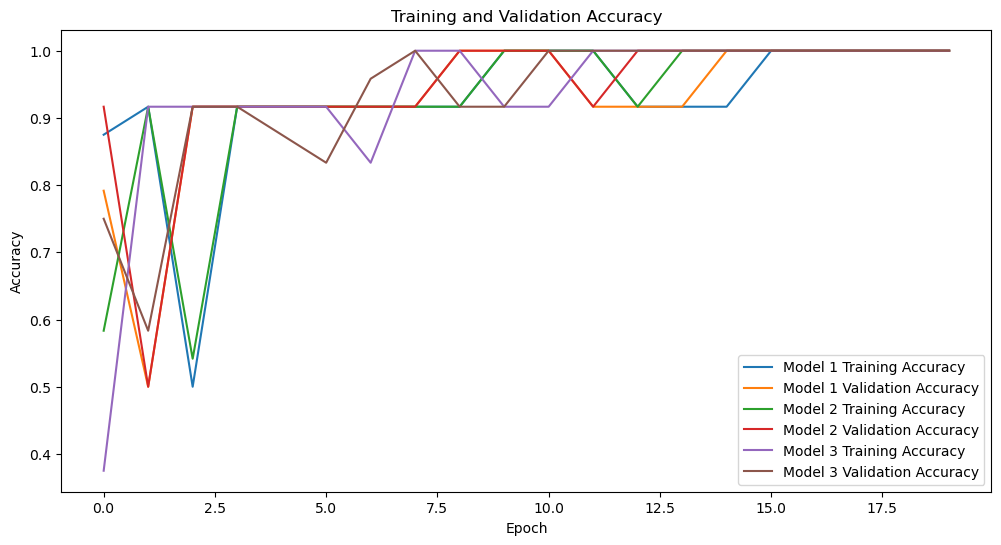

In [34]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
 
# 1. Define the CNN model function
def create_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(2, activation='softmax')  # Adjust based on your number of classes
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
 
# 2. Load your data
train_dir = 'C:/Users/vikra/Downloads/Naveen/images 1/images/train2'
validation_dir = 'C:/Users/vikra/Downloads/Naveen/images 1/images/valid2'
test_dir = 'C:/Users/vikra/Downloads/Naveen/images 1/images/test2'
 
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse'
)
 
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse'
)
 
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)
 
input_shape = (128, 128, 3)  # Example input shape
 
# 3. Create and train multiple CNN models
num_models = 3
models = []
history_list = []
 
for i in range(num_models):
    model = create_cnn_model(input_shape)
    print(f"Training Model {i+1}")
    history = model.fit(train_generator, epochs=20, validation_data=validation_generator, verbose=1)
    models.append(model)
    history_list.append(history)
 
# 4. Define the ensemble prediction function
def ensemble_predict(models, generator):
    num_samples = generator.samples
    num_classes = generator.num_classes
    predictions = np.zeros((num_samples, num_classes))
    for model in models:
        model_predictions = model.predict(generator, steps=num_samples // generator.batch_size + 1)
        predictions += model_predictions / len(models)
    return np.argmax(predictions, axis=1)
 
# 5. Evaluate the ensemble model
def get_test_labels(generator):
    num_samples = generator.samples
    test_labels = np.array([])
    for _ in range(num_samples // generator.batch_size + 1):
        batch = generator.next()
        test_labels = np.concatenate([test_labels, batch[1]], axis=0)
        if len(test_labels) >= num_samples:
            break
    return test_labels[:num_samples]
 
test_labels = get_test_labels(test_generator)
predictions = ensemble_predict(models, test_generator)
 
# Calculate accuracy
accuracy = accuracy_score(test_labels, predictions)
print(f'Ensemble Test Accuracy: {accuracy}')
 
# 6. Plot training history
def plot_history(history_list):
    plt.figure(figsize=(12, 6))
    for i, history in enumerate(history_list):
        plt.plot(history.history['accuracy'], label=f'Model {i+1} Training Accuracy')
        plt.plot(history.history['val_accuracy'], label=f'Model {i+1} Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
 
plot_history(history_list)

Evaluating Model 1
2/2 [==============================] - 4s 2s/step - loss: 3.7650 - accuracy: 0.4667
Evaluating Model 2
2/2 [==============================] - 4s 2s/step - loss: 5.2464 - accuracy: 0.4667
Evaluating Model 3
2/2 [==============================] - 4s 2s/step - loss: 3.9310 - accuracy: 0.4667
Model 1 - Test Loss: 3.7649614810943604, Test Accuracy: 0.46666666865348816
Model 2 - Test Loss: 5.246421813964844, Test Accuracy: 0.46666666865348816
Model 3 - Test Loss: 3.93097186088562, Test Accuracy: 0.46666666865348816


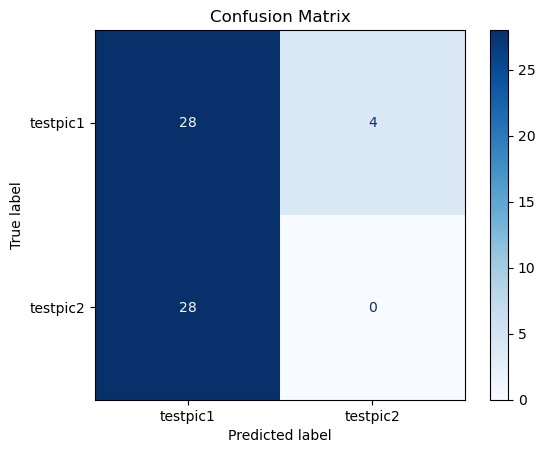

In [35]:
# Evaluate individual models on test data
def evaluate_models(models, test_generator):
    results = []
    for i, model in enumerate(models):
        print(f"Evaluating Model {i+1}")
        loss, accuracy = model.evaluate(test_generator, verbose=1)
        results.append((loss, accuracy))
    return results
 
# Get individual model evaluations
model_results = evaluate_models(models, test_generator)
 
# Print individual model results
for i, (loss, accuracy) in enumerate(model_results):
    print(f"Model {i+1} - Test Loss: {loss}, Test Accuracy: {accuracy}")
 
# Plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
 
def plot_confusion_matrix(test_labels, predictions):
    cm = confusion_matrix(test_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
 
plot_confusion_matrix(test_labels, predictions)